# **Taxi Fare Amount: NewYork Taxi Cost Prediction**



<h1> Big Data Computing Project - A.Y. 2019/2020</h1> </br>
<h2>Students:</h2>

*   Bacciu Andrea
*   Taiello Riccardo

</br>
<h2>Professor:</h2>

*  Tolomei Gabriele

![alt text](https://i2.res.24o.it/images2010/Editrice/ILSOLE24ORE/VIAGGI24/2019/12/07/Viaggi24/ImmaginiWeb/Ritagli/taxi-new-york-agf-197SCA00437-kYFB--1020x533@IlSole24Ore-Web.jpg)

# Dependencies

In [ ]:
!pip install pyspark==2.4.6
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install geopy
from google.colab import drive
drive.mount('/content/drive')  

     |████████████████████████████████| 218.4MB 23kB/s 
     |████████████████████████████████| 204kB 56.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814406 sha256=28da8cf75c2e149508779794f80b65441f4c0c25fa44a3ee4b982ea9825a3601
  Stored in directory: /root/.cache/pip/wheels/1e/5e/6a/17e906c94ec7246f260330a66e44a06a0809033ba2738a74a8
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 33 not upgraded.
Need to get 35.8 MB of archives.
After this 

## **Global Constants**

In [ ]:
SEED = 42 
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64" # Set path to JAVA_HOME
PYTHON_HOME = "/usr/bin/python3.6"
SUBMIT_ARGS = "--packages com.microsoft.ml.spark:mmlspark_2.11:0.18.1 pyspark-shell" # Add Azure dependecy

## **Dataset path**

### ⚠️ **Set this path according to your GDrive**



In [ ]:
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive/Colab Notebooks"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BigData/1747105_1914000/taxi-fare-amount"

In [ ]:
PATH_DATASET = GDRIVE_DATA_DIR+"/processed/master/merged_dataset.csv"
PATH_PREPROCESSED = GDRIVE_DATA_DIR+"/processed"
PATH_PICKLE = GDRIVE_DATA_DIR+"/pickle"

## **Other path**

In [ ]:
PATH_ML_MODEL = PATH_PICKLE = GDRIVE_DATA_DIR+"/machine-learning-model"
PATH_PIPELINE = PATH_ML_MODEL + "/pipeline"
PATH_PIPELINE_MODEL = PATH_ML_MODEL + "/pipeline_model"
PATH_FINAL_MODEL = PATH_ML_MODEL + "/final_model"

PATH_PIPELINE_LR = PATH_PIPELINE + "/lr_best_pipeline"
PATH_PIPELINE_MODEL_LR = PATH_PIPELINE_MODEL + "/lr_best_pipeline_model"

PATH_PIPELINE_LGBM = PATH_PIPELINE+"/lgbm_best_pipeline"
PATH_PIPELINE_MODEL_LGBM = PATH_PIPELINE_MODEL+"/lgbm_best_pipeline_model"

PATH_PIPELINE_RF = PATH_PIPELINE+"rf_best_pipeline"
PATH_PIPELINE_MODEL_RF = PATH_PIPELINE_MODEL+"/rf_best_pipeline_model"

# Python import & settings the Spark env

In [ ]:
import os
import pickle
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PYSPARK_PYTHON"] = PYTHON_HOME
os.environ["PYSPARK_DRIVER_PYTHON"] = PYTHON_HOME
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [ ]:
# PySpark modules
import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import pyspark.sql.functions as f

# others usefull modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Spark nstanciation
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')
# Create the context
sc = pyspark.SparkContext(conf=conf)
spark =  pyspark.sql.SparkSession.builder.appName("TaxiFareAmount") \
            .getOrCreate()


In [ ]:
spark

## **Load dataset into a Spark Dataframe**




In [ ]:
taxi_df = spark.read.load(PATH_DATASET, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

In [ ]:
# See all features' type
taxi_df.dtypes

[('key', 'timestamp'),
 ('fare_amount', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('real_distance', 'double'),
 ('pickup_datetime', 'string')]

## **Init features and target variable**

In [ ]:
TARGET_VARIABLE = "fare_amount" # Label 
NUMERICAL_FEATURES = ["key","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","real_distance"]
CATEGORICAL_FEATURES = [] 

# **1. Feature engineering**


NOTE (1): The dataset loaded has the real_distance feature which is created using the OpenStreetMap API see [here](#osmr)

NOTE (2): In order to increase the speed, we preprocess the dataset deleting the outlier and stored into the Google Drive folder.

For clarity: **However we show which are steps perfomed to clean the dataset. We marked it with (*)**



##  **1.1. Pre-processing(*)**

 Clean Spark Dataframe from noise samples: 

1.   latitude and logitude out of min and max of New York City;
2.   fare amount negative and too large (>= 250);
3.   We removed all sample with the same coordinates of the arrival and departures.



In [ ]:
def clean(df, delimiter_coordinate=True, delimiter_outliers=True):
    # Remove incosistent rows, no sense that start coordinate are equals to end coordinate
    # STEP 3
    df = df.filter(f.col("dropoff_longitude") != f.col("pickup_longitude"))
    df = df.filter(f.col("dropoff_latitude") != f.col("pickup_latitude"))
    # Delimiter lats and lons to NY only
    # STEP 1
    if delimiter_coordinate:
      df = df.filter((f.col("pickup_longitude") >= -76) & (f.col("pickup_longitude") <= -72))  
      df = df.filter((f.col("dropoff_longitude") >= -76) & (f.col("dropoff_longitude") <= -72))
      df = df.filter((f.col("pickup_latitude") >= 38) & (f.col("pickup_latitude") <= 42)) 
      df = df.filter((f.col("dropoff_latitude") >= 38) & (f.col("dropoff_latitude") <= 42))

    # Remove possible outliers
    # STEP 2
    if delimiter_outliers:
      df = df.filter((f.col("fare_amount") > 0) & (f.col("fare_amount") <=250)) # df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]

    return df

In [ ]:
print("The shape of the dataset before clean() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))
taxi_df = clean(taxi_df,delimiter_coordinate=True,delimiter_outliers=True)
print("The shape of the dataset after clean() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))

The shape of the dataset before clean() is 3873028 rows by 9 columns
The shape of the dataset after clean() is 3873028 rows by 9 columns


We compare the shape of the loaded dataset from Google Drive folder and the just loaded.

As you can see it doens't change.






## **1.2. Feature extraction**

**User Define Function -- UDF**

This section performs some computation step using the Spark's UDF. </br> 
UDF takes as input a row and a function, then apply the function to the row

To deal with datetime feature it's common pratice split it into several features, which are rappresented by:

1.   Minute;
2.   hour;
3.   day number during the week (from 1 to 7);
4.   day number during the month;
5.   year;

This approach lets to the ML models to handle this informations in a powerful way, therefore it might improve the final perfomance. 

In [ ]:
# Boolean parameters allow us to get much flexibility.
def split_datetime(df, minute: bool = True, hour: bool=True, day_week: bool = True, day_of_month: bool = True, year: bool=True):
    if minute:
      df = df.withColumn("minute", f.minute("key"))    
    if hour:
      df = df.withColumn("hour", f.hour("key"))
    if day_week:
      df = df.withColumn("day_of_week", f.dayofweek("key"))
    if day_of_month:
      df = df.withColumn("day_of_month", f.dayofmonth("key"))
    if year:
      df = df.withColumn("year", f.year("key"))
    return df

In [ ]:
# As we can see we add new 5 features
print("The shape of the dataset before split_datetime() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))
taxi_df = split_datetime(df=taxi_df)
print("The shape of the dataset after split_datetime() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))

The shape of the dataset before split_datetime() is 3873028 rows by 9 columns
The shape of the dataset after split_datetime() is 3873028 rows by 14 columns


In [ ]:
# Update the features list
NUMERICAL_FEATURES.append("minute")
NUMERICAL_FEATURES.append("hour")
NUMERICAL_FEATURES.append("day_of_week")
NUMERICAL_FEATURES.append("day_of_month")
NUMERICAL_FEATURES.append("year")

NUMERICAL_FEATURES.remove("key")

In [ ]:
taxi_df.dtypes

[('key', 'timestamp'),
 ('fare_amount', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('real_distance', 'double'),
 ('pickup_datetime', 'string'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day_of_week', 'int'),
 ('day_of_month', 'int'),
 ('year', 'int')]

###**1.2.2. NY implements diffent surplus tax based on the day and the hour's window**



To take into account, we add two features which describe the chance to have an extra fare_amount </br> For further info see : https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

In [ ]:
from pyspark.sql.types import BooleanType
def add_surchage(df, rush_hour: bool = True, night: bool = True):
    
  def is_rush_hour(hour: int, day_of_week: int) -> bool:
    return day_of_week <=5 and (hour>=16 and hour <=20)

  def is_night(hour: int) -> bool:
    return hour >= 20 or hour <= 6

  if rush_hour :
    is_rush_hour_udf = f.udf(lambda x,y: is_rush_hour(x,y), BooleanType())
    df = df.withColumn("is_rush_hour",is_rush_hour_udf(f.col("hour"),f.col("day_of_week")))

  if night :
    is_night_udf =  f.udf(lambda x: is_night(x), BooleanType())
    df = df.withColumn("is_night",is_night_udf(f.col("hour")))

  return df

In [ ]:
print("The shape of the dataset before add_surchage() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))
taxi_df = add_surchage(df=taxi_df)
print("The shape of the dataset after add_surchage() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))

The shape of the dataset before add_surchage() is 3873028 rows by 14 columns
The shape of the dataset after add_surchage() is 3873028 rows by 16 columns


In [ ]:
taxi_df.dtypes

[('key', 'timestamp'),
 ('fare_amount', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('real_distance', 'double'),
 ('pickup_datetime', 'string'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day_of_week', 'int'),
 ('day_of_month', 'int'),
 ('year', 'int'),
 ('is_rush_hour', 'boolean'),
 ('is_night', 'boolean')]

In [ ]:
# Update features list
CATEGORICAL_FEATURES.append("is_rush_hour")
CATEGORICAL_FEATURES.append("is_night")

##**1.3. Airport Feature** </br>
We used 3 dummy features (binary type), one foreach airport:


1.   JFK 
2.   LGA
3.   EWR
</br>
For istance wether pickup or dropoff belonged to JFK the feature JFK is equals to True, the same rule of thumb for the others airports. The idea behind the scene is illustrated in the photo below.

![alt text](https://drive.google.com/uc?id=1OtJA2Pktt7UoRY785x08L55dH3qNnaKZ)

In [ ]:
# Utility function, which takes the start coordinate and end coordinate and return true if one of them is whitin an NY airport

def airport_delimiter(min_latitude, max_latitude, min_longitude, max_longitude, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    
  pickup_delimiter_latitude = (pickup_latitude >= min_latitude) and (pickup_latitude <= max_latitude) 
  pickup_delimiter_longitude = (pickup_longitude >= min_longitude) and (pickup_longitude <= max_longitude)
  dropoff_delimiter_latitude = (dropoff_latitude >= min_latitude) and (dropoff_latitude <= max_latitude) 
  dropoff_delimiter_longitude = (dropoff_longitude >= min_longitude) and (dropoff_longitude <= max_longitude)
  is_airport = (pickup_delimiter_latitude and pickup_delimiter_longitude) or (dropoff_delimiter_latitude and dropoff_delimiter_longitude)
  return is_airport
      
def add_airports(df, jfk = True, ewr = True, lga=True):
  from pyspark.sql.types import BooleanType
  if jfk:
    add_jfk_udf = f.udf(lambda x, y, w, z:airport_delimiter(40.624845,40.66590,-73.821974,-73.745499,x,y,w,z), BooleanType())
    df = df.withColumn("jfk_airport", (add_jfk_udf(f.col("pickup_latitude"),f.col("pickup_longitude"),f.col("dropoff_latitude"),f.col("dropoff_longitude"))))
  
  if ewr:
    add_ewr_udf = f.udf(lambda  x, y, w, z:airport_delimiter(40.670851,40.708338,-74.194669,-74.153213,x,y,w,z), BooleanType())
    df = df.withColumn("ewr_airport", (add_ewr_udf(f.col("pickup_latitude"),f.col("pickup_longitude"),\
                                                                     f.col("dropoff_latitude"),f.col("dropoff_longitude"))))
  if lga:
    add_lga_udf = f.udf(lambda  x, y, w, z:airport_delimiter(40.764928,40.783843,-73.887967,-73.854150,x,y,w,z), BooleanType()) 
    df = df.withColumn("lga_airport", (add_lga_udf(f.col("pickup_latitude"),f.col("pickup_longitude"),\
                                                                      f.col("dropoff_latitude"),f.col("dropoff_longitude"))))
  return df

**Check if everything works**

In [ ]:
airport_delimiter(40.624845,40.66590,-73.821974,-73.745499,40.64749,-73.77998209999998,-73.821974,-73.745499)

True

In [ ]:
print("The shape of the dataset before add_airports() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))
taxi_df = add_airports(df=taxi_df)
print("The shape of the dataset after add_airports() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))

The shape of the dataset before add_airports() is 3873028 rows by 16 columns
The shape of the dataset after add_airports() is 3873028 rows by 19 columns


We add the new Aiport Features

In [ ]:
CATEGORICAL_FEATURES.append("jfk_airport")
CATEGORICAL_FEATURES.append("ewr_airport")
CATEGORICAL_FEATURES.append("lga_airport")

In [ ]:
taxi_df.dtypes

[('key', 'timestamp'),
 ('fare_amount', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('real_distance', 'double'),
 ('pickup_datetime', 'string'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day_of_week', 'int'),
 ('day_of_month', 'int'),
 ('year', 'int'),
 ('is_rush_hour', 'boolean'),
 ('is_night', 'boolean'),
 ('jfk_airport', 'boolean'),
 ('ewr_airport', 'boolean'),
 ('lga_airport', 'boolean')]

## 1.4 Distance feature

###**1.4.1 Haversine Distance**

In [ ]:
def haversine_distance_km(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    import geopy.distance
    # see https://kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python
    coords_1 = (pickup_latitude, pickup_longitude)        
    coords_2 = (dropoff_latitude, dropoff_longitude)
    km_distance = geopy.distance.distance(coords_1, coords_2).km       

    return km_distance

def add_haversine(df):
    from pyspark.sql.types import DoubleType, IntegerType
    # create udf to iterate over Spark Dataframe see https://changhsinlee.com/pyspark-udf/
    haversine_distance_km_udf = f.udf(lambda x, y, w, z: haversine_distance_km(x, y, w, z), DoubleType())

    df = df.withColumn("haversine_distance_km", (haversine_distance_km_udf(f.col("pickup_latitude"),f.col("pickup_longitude"),\
                                                                     f.col("dropoff_latitude"),f.col("dropoff_longitude"))))    
    return df


In [ ]:
print("The shape of the dataset before add_distance() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))
taxi_df = add_haversine(taxi_df)
print("The shape of the dataset before add_distance() is {:d} rows by {:d} columns".format(taxi_df.count(), len(taxi_df.columns)))

The shape of the dataset before add_distance() is 3873028 rows by 19 columns
The shape of the dataset before add_distance() is 3873028 rows by 20 columns


In [ ]:
# Update features
NUMERICAL_FEATURES.append("haversine_distance_km")

In [ ]:
taxi_df.dtypes

[('key', 'timestamp'),
 ('fare_amount', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('real_distance', 'double'),
 ('pickup_datetime', 'string'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day_of_week', 'int'),
 ('day_of_month', 'int'),
 ('year', 'int'),
 ('is_rush_hour', 'boolean'),
 ('is_night', 'boolean'),
 ('jfk_airport', 'boolean'),
 ('ewr_airport', 'boolean'),
 ('lga_airport', 'boolean'),
 ('haversine_distance_km', 'double')]

### **1.4.2 Waze API**

![alt text](https://images.wired.it/wp-content/uploads/2019/03/26180339/WAZE_Traffico_Intelligenza_Artificiale.png)



In [ ]:
#@title Implementation of WAZE API (IT'S JUST AN EXAMPLE, DON'T RUN IT)
!pip install WazeRouteCalculator


def waze_api(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
  import WazeRouteCalculator
  result = 0.0
  while(result==0):
    from_address = str(pickup_latitude) + ", " + str(pickup_longitude)
    to_address = str(dropoff_latitude)+ ", " + str(dropoff_longitude)
    region = 'US'
    vehicle_type = "TAXI" # TAXI heuristics
    try:
      route = WazeRouteCalculator.WazeRouteCalculator(from_address, to_address, region,vehicle_type=vehicle_type)
      result = route.calc_route_info(real_time=False)[1]
    except:
      pass
  print("ok ")
  return result

def add_waze_time(df):
  add_waze_times_udf = f.udf(lambda x, y, w, z: waze_api(x, y, w, z), DoubleType())
  
  df = df.withColumn("waze_time", (add_waze_times_udf(f.col("pickup_latitude"),f.col("pickup_longitude"),\
                                                                  f.col("dropoff_latitude"),f.col("dropoff_longitude"))))
  return df

waze_api( 40.721287,-74.00981800000001,  40.7671, -73.95695)
waze_api(40.7073,-73.966709,40.756196,-74.011909)    
waze_api( 40.762112,-73.97914499999999,40.758815000000006,-73.995648)   

  Created wheel for WazeRouteCalculator: filename=WazeRouteCalculator-0.12-cp36-none-any.whl size=4495 sha256=8e2cc1cbd4c432251a8f9fecbecad331b5247896f148c42658836e0acbc02b00
  Stored in directory: /root/.cache/pip/wheels/b6/4b/01/435309a78d48505ca8ca715ceb43011a2255f891b8d214ffbd
Successfully built WazeRouteCalculator
ok 
ok 
ok 


2.007

<a id='osmr'></a>

### **1.4.3 OpenStreetMap Routing**



![alt text](https://drive.google.com/uc?id=1IevrJ0wX1WFCBfjZR7KB7oWsrH0LKuhs)


See GitHub repository https://github.com/Project-OSRM/osrm-backend

We dowloaded the Docker Image of the NY Map server. </br>
Below how it works the OpenStreetMap Docker container.

![alt text](https://drive.google.com/uc?id=1Sh97s_Wn9rJHSJMeoKn1Uh-eIIk_XRLk)


The script which we used to calculate the real_distance, interacting with the Docker Container.


![alt text](https://drive.google.com/uc?id=1xSjQFtCllxQ8VRXNc_BmkzenOSUKrOtN)


## **1.5 Feature transformation + a few EDA scratches**

**TO AVOID DATA LEAKAGE, WE SPLIT OUR DATASET, SINCE WE WILL PERFORM SEVERAL TRANSFORMATION USING JUST THE TRAIN DATASET. TROUGH THE TRANSFORMATION OBTAINED FROM THE TRAIN DATA, WE WILL COMPUTE THE TRANSFORMED FEATURE FOR TRAIN AND TEST**

In [ ]:
SPEED = True # if True we skip split and we use the (stored) splitted dataset 
USE_PICKLE = False # We use pickle to load the scaler
PATH_DATASET_TRAIN = PATH_PREPROCESSED + "/train/dataset_train.csv"
PATH_DATASET_VAL = PATH_PREPROCESSED + "/val/dataset_val.csv"
PATH_DATASET_TEST = PATH_PREPROCESSED + "/test/dataset_test.csv"

In [ ]:
if SPEED is False:
  taxi_df, taxi_df_test, taxi_df_val = taxi_df.randomSplit([0.8, 0.1, 0.1], seed=SEED)
  # Write the csv file of train into GDrive the name is merged_dataset_train.csv
  
  taxi_pd = taxi_df.toPandas()
  taxi_pd_val = taxi_df_val.toPandas()
  taxi_pd_test =  taxi_df_test.toPandas()

Since the toPandas() (the cell above) which converts Spark DF into Pandas DF needs too much time, we import directly the temporany datasets using pandas.

**Split into train and validation**

In [ ]:
if SPEED:
  taxi_pd = pd.read_csv(PATH_DATASET_TRAIN)
  taxi_pd_val  = pd.read_csv(PATH_DATASET_VAL)
  taxi_pd_test = pd.read_csv(PATH_DATASET_TEST)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
plt.style.use("fivethirtyeight")

**One of the problems with histograms is the choose about the bin size. A better alternative to histogram is plotting Empirical cumulative distribution functions (ECDFs). ECDFs don’t have the binning issue and are great for visualizing many distributions together.**

In [ ]:
def ecdf(data):
    # Empirical Cumulative Distribution Function
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

### 1.5.1. **EDA + log-transformation *fare_amount*** 

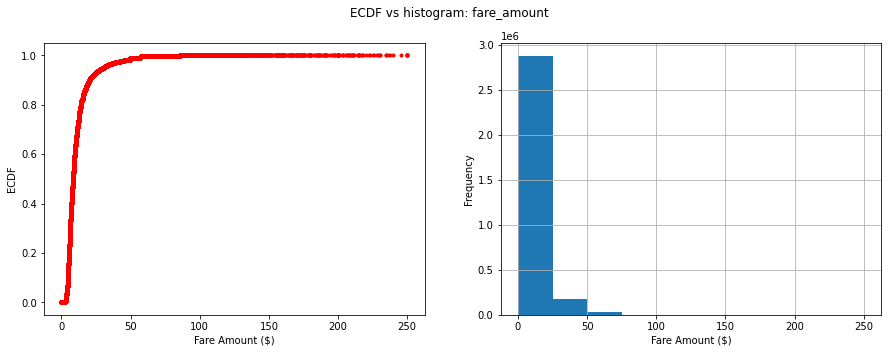

In [ ]:
x_fare_amount, y_fare_amount = ecdf(taxi_pd.fare_amount)

# Generate plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('ECDF vs histogram: fare_amount')
ax1.plot(x_fare_amount,y_fare_amount, marker='.', linestyle= 'none',color='red')
ax1.set(xlabel='Fare Amount ($)', ylabel='ECDF')

taxi_pd.fare_amount.hist(ax=ax2)
ax2.set(xlabel='Fare Amount ($)', ylabel='Frequency')

# Display the plot
plt.show()

Looking the graph, the curve shows that almost the 95% of the entiry population have a fare_amount less than 50. Therefore we could apply a log transformation in order to remove ''skewed'' from the data distribution

In [ ]:
from sklearn.preprocessing import PowerTransformer
scaler_fare_amount = PowerTransformer() # log transformation
TARGET_FEATURE = taxi_pd.fare_amount.to_numpy().reshape(-1,1)


scaler_fare_amount.fit(TARGET_FEATURE)
taxi_pd['log_fare_amount'] = scaler_fare_amount.transform(TARGET_FEATURE)

**`Plot the created feature`**

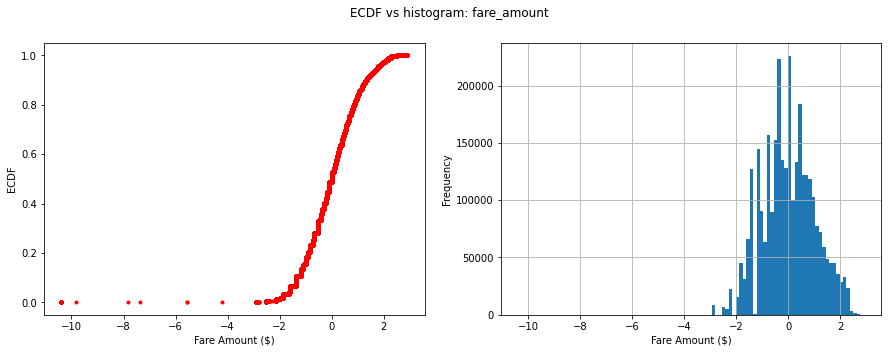

In [ ]:
x_log_fare_amount, y_log_fare_amount = ecdf(taxi_pd.log_fare_amount)

x_fare_amount, y_fare_amount = ecdf(taxi_pd.fare_amount)

# Generate plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('ECDF vs histogram: fare_amount')
ax1.plot(x_log_fare_amount,y_log_fare_amount, marker='.', linestyle= 'none',color='red')
ax1.set(xlabel='Fare Amount ($)', ylabel='ECDF')

taxi_pd.log_fare_amount.hist(ax=ax2, bins=100)
ax2.set(xlabel='Fare Amount ($)', ylabel='Frequency')

# Display the plot
plt.show()

We perform the 97 % confident interval, in order to remove several ''outliers'', after do that we count how many outliers we rule out.

In [ ]:
min = taxi_pd['fare_amount'].min()
max = taxi_pd['fare_amount'].max()
print("min = "+str(min))
print("max = "+str(max))

min = 0.01
max = 250.0


In [ ]:
ninthyseven_ci= np.percentile(taxi_pd.log_fare_amount,[1.5,98.5])
mean = np.mean(taxi_pd.log_fare_amount)
cut_off_lower = ninthyseven_ci[0]
cut_off_upper = ninthyseven_ci[1]

In [ ]:
lower, upper = cut_off_lower,cut_off_upper

In [ ]:
upper_cutted = len(taxi_pd[(taxi_pd['log_fare_amount'] > upper)==True])
lower_cutted = len(taxi_pd[(taxi_pd['log_fare_amount'] < lower )==True])
print("Number of samples ruled out, cut_off_lower {:d}, cut_of_upper {:d}".format(lower_cutted, upper_cutted))

Number of samples ruled out, cut_off_lower 44323, cut_of_upper 39258


**WE APPLING THIS TRANSFORMATION JUST FOR THE TRAIN**

In [ ]:
taxi_pd = taxi_pd[(taxi_pd['log_fare_amount'] < upper) &
(taxi_pd['log_fare_amount'] > lower)]

In [ ]:
min = taxi_pd['fare_amount'].min()
max = taxi_pd['fare_amount'].max()
print("min = " + str(min))
print("max = " + str(max))

min = 3.61
max = 49.79


### **1.5.2. EDA + log-transformation *real_distance***


In [ ]:
if USE_PICKLE is False:
  scaler = PowerTransformer() # log transformation
  TARGET_FEATURE = taxi_pd.real_distance.to_numpy().reshape(-1,1)
  TARGET_FEATURE_VAL = taxi_pd_val.real_distance.to_numpy().reshape(-1,1)
  TARGET_FEATURE_TEST = taxi_pd_test.real_distance.to_numpy().reshape(-1,1)

  scaler.fit(TARGET_FEATURE)
  taxi_pd['log_real_distance'] = scaler.transform(TARGET_FEATURE)
  taxi_pd_val['log_real_distance'] = scaler.transform(TARGET_FEATURE_VAL)
  taxi_pd_test['log_real_distance'] = scaler.transform(TARGET_FEATURE_TEST)

In [ ]:
%%bash
ls "/content/drive/My Drive/Colab Notebooks/BigData/1747105_1914000/taxi-fare-amount/pickle/"

PowerTransformer.pkl


In [ ]:
power_transfomer_pickle_filename = PATH_PICKLE + "/PowerTransformer.pkl"
if USE_PICKLE is False:
  with open(power_transfomer_pickle_filename, "wb") as power_transfomer_pickle:
    pickle.dump(scaler, power_transfomer_pickle)
else:
  with open(power_transfomer_pickle_filename, "rb") as power_transfomer_pickle:
    scaler = pickle.load(power_transfomer_pickle)

**Plot the created feature**

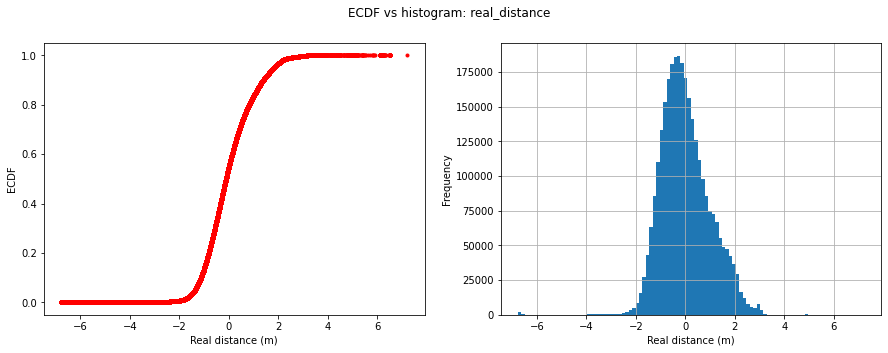

In [ ]:
x_log_real_distance, y_log_real_distance = ecdf(taxi_pd.log_real_distance)
# Generate plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('ECDF vs histogram: real_distance')
ax1.plot(x_log_real_distance,y_log_real_distance, marker='.', linestyle= 'none',color='red')
ax1.set(xlabel='Real distance (m)', ylabel='ECDF')

taxi_pd.log_real_distance.hist(ax=ax2, bins=100)
ax2.set(xlabel='Real distance (m)', ylabel='Frequency')

# Display the plot
plt.show()

**REMOVE OUTLIERS USING REAL_DISTANCE**

In [ ]:
min = taxi_pd['real_distance'].min()
max = taxi_pd['real_distance'].max()
print("min = " + str(min))
print("max = " + str(max))

min = 0.0
max = 337384.6


In [ ]:
ninthyeight_ci= np.percentile(taxi_pd.log_real_distance,[1,99])
cut_off_lower = ninthyeight_ci[0]
cut_off_upper = ninthyeight_ci[1]

In [ ]:
lower, upper = cut_off_lower, cut_off_upper

In [ ]:
upper_cutted = len(taxi_pd[(taxi_pd['log_real_distance'] > upper) == True])
lower_cutted = len(taxi_pd[(taxi_pd['log_real_distance'] < lower ) == True])
print("Number of samples ruled out, cut_off_lower {:d}, cut_of_upper {:d}".format(lower_cutted, upper_cutted))

Number of samples ruled out, cut_off_lower 29892, cut_of_upper 29904


In [ ]:
taxi_pd = taxi_pd[(taxi_pd['log_real_distance'] < upper) &
(taxi_pd['log_real_distance'] > lower)]

In [ ]:
taxi_pd_val = taxi_pd_val[(taxi_pd_val['log_real_distance'] < upper) &
(taxi_pd_val['log_real_distance'] > lower)]

In [ ]:
min = taxi_pd['fare_amount'].min()
max = taxi_pd['fare_amount'].max()
print("min = "+str(min)) # min = 3.7
print("max = "+str(max)) # max = 49.79

min = 3.7
max = 49.75


### **1.5.3. Airport analysis (off-topic)**


We applied here, since with Pandas DF we can do lot of things rather than SparkDF

In [ ]:
import pandas as pd

In [ ]:
taxi_pd = pd.read_csv(PATH_PREPROCESSED+"/train/transformed_dataset_train.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
jfk = taxi_pd[taxi_pd.jfk_airport == True]
jfk.describe().fare_amount.T

count    11672.000000
mean        26.036149
std         10.551278
min          3.700000
25%         18.100000
50%         26.500000
75%         33.500000
max         49.700000
Name: fare_amount, dtype: float64

In [ ]:
ewr = taxi_pd[taxi_pd.ewr_airport == True]
ewr.describe().fare_amount.T

count     8.000000
mean      9.850000
std       4.684015
min       4.900000
25%       7.100000
50%       8.500000
75%      10.800000
max      19.300000
Name: fare_amount, dtype: float64

In [ ]:
lga = taxi_pd[taxi_pd.lga_airport == True]
lga.describe().fare_amount.T

count    96585.000000
mean        30.183309
std          7.984271
min          3.700000
25%         26.250000
50%         30.500000
75%         35.300000
max         49.700000
Name: fare_amount, dtype: float64

In [ ]:
NUMERICAL_FEATURES.append("log_real_distance")

In [ ]:
NUMERICAL_FEATURES.remove("real_distance")

In [ ]:
taxi_pd.to_csv(PATH_PREPROCESSED+"/train/transformed_dataset_train.csv",index=False)
taxi_pd_val.to_csv(PATH_PREPROCESSED+"/val/transformed_dataset_val.csv",index=False)
taxi_pd_test.to_csv(PATH_PREPROCESSED+"/test/transformed_dataset_test.csv",index=False)

# **2. Machine learning models**

## **Task Evalution Metrics**

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^{2}}$$

##**Load train and test dataset**

In [ ]:
taxi_df = spark.read.load(PATH_PREPROCESSED+"/train/transformed_dataset_train.csv", 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

In [ ]:
taxi_df_val = spark.read.load(PATH_PREPROCESSED+"/val/transformed_dataset_val.csv", 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

In [ ]:
USE_PICKLE = True

In [ ]:
taxi_df.dtypes

[('key', 'timestamp'),
 ('fare_amount', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('real_distance', 'double'),
 ('pickup_datetime', 'string'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day_of_week', 'int'),
 ('day_of_month', 'int'),
 ('year', 'int'),
 ('is_rush_hour', 'boolean'),
 ('is_night', 'boolean'),
 ('jfk_airport', 'boolean'),
 ('ewr_airport', 'boolean'),
 ('lga_airport', 'boolean'),
 ('haversine_distance_km', 'double'),
 ('log_fare_amount', 'double'),
 ('log_real_distance', 'double')]

In [ ]:
taxi_df_val.dtypes

[('key', 'string'),
 ('fare_amount', 'double'),
 ('pickup_longitude', 'double'),
 ('pickup_latitude', 'double'),
 ('dropoff_longitude', 'double'),
 ('dropoff_latitude', 'double'),
 ('passenger_count', 'int'),
 ('real_distance', 'double'),
 ('pickup_datetime', 'string'),
 ('minute', 'int'),
 ('hour', 'int'),
 ('day_of_week', 'int'),
 ('day_of_month', 'int'),
 ('year', 'int'),
 ('is_rush_hour', 'boolean'),
 ('is_night', 'boolean'),
 ('jfk_airport', 'boolean'),
 ('ewr_airport', 'boolean'),
 ('lga_airport', 'boolean'),
 ('haversine_distance_km', 'double'),
 ('log_real_distance', 'double')]

In [ ]:
NUMERICAL_FEATURES = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude","passenger_count",\
                      "log_real_distance","minute","hour","day_of_week","day_of_month","year","haversine_distance_km"]
CATEGORICAL_FEATURES = ["is_night", "is_rush_hour", "jfk_airport", "ewr_airport", "lga_airport"]
TARGET_VARIABLE = "fare_amount"

## **2.1. Linear Regression**

In [ ]:
def get_best_params(best_mod) -> dict:
  # arg: grid_search model 
  # return: dict with the best set of hyperparameters
  param_dict = best_mod.stages[-1].extractParamMap()
  print(param_dict)
  best_params_dict = {}
  for k, v in param_dict.items():
    best_params_dict[k.name] = v
  return best_params_dict

In [ ]:
def cv_linear_regression(train,
                          numerical_features, 
                          categorical_features, 
                          target_variable, 
                          with_std=True,
                          with_mean=True,
                          k_fold=5):
    
    from pyspark.ml.feature import VectorAssembler, StandardScaler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.regression import LinearRegression
    from pyspark.ml import Pipeline   
    # 1. Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=numerical_features + categorical_features, outputCol="features")

    # 2. Create the StandardScaler
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)


    if TARGET_VARIABLE != "label":
        train = train.withColumnRenamed(TARGET_VARIABLE, "label")

    lr = LinearRegression(featuresCol="std_features", labelCol="label") # change `featuresCol=std_features` if scaler is used
    
    pipeline = Pipeline(stages=[assembler] + [scaler]+ [lr]) # add/remove `[scaler]` to the pipeline if needed

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for lr.regParam ($\lambda$) and 3 values for lr.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                              estimatorParamMaps=param_grid,
                              evaluator=RegressionEvaluator(metricName="rmse"),
                              numFolds=k_fold,
                              collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                              )

    # Run cross-validation, and choose the best set of parameters.

    cv_model = cross_val.fit(train)
    best_pipeline_model = cv_model.bestModel
    # After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset.
    return cv_model, best_pipeline_model
  

In [ ]:
def linear_regression_pipeline(train,
                               numerical_features, 
                               categorical_features, 
                               target_variable, 
                               with_std=True,
                               with_mean=True,
                               k_fold=5,
                               saved = False):
   if saved :
       from pyspark.ml import PipelineModel
       best_pipeline = PipelineModel.load(PATH_PIPELINE_MODEL_LR)
       return None, best_pipeline
   else:
        cv_model, best_pipeline = cv_linear_regression(train,numerical_features, categorical_features, target_variable,  with_std = with_std , with_mean=with_mean, k_fold=k_fold) 
        best_pipeline.save(PATH_PIPELINE_MODEL_LR)   
        return cv_model, best_pipeline

In [ ]:
cv_model, best_pipeline_model_lr = linear_regression_pipeline(taxi_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE, saved = USE_PICKLE)

In [ ]:
check_cv_model = cv_model is None and USE_PICKLE is True
assert ((check_cv_model) or (not check_cv_model))

In [ ]:
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
if USE_PICKLE is False:
  summarize_all_models(cv_model.subModels)

### **2.1.1. Train dataset score**

In [ ]:
predictions_train = best_pipeline_model_lr.transform(taxi_df)

In [ ]:
def evaluate_model(predictions, metric="rmse"):
    
    from pyspark.ml.evaluation import RegressionEvaluator

    evaluator = RegressionEvaluator(labelCol="fare_amount",
                                    predictionCol="prediction",
                                    metricName=metric)

    return evaluator.evaluate(predictions)

In [ ]:
def r2_adj(predictions):
    
    r2 = evaluate_model(predictions, metric="r2")
    r2_adj_score = (1 - (1 - r2) * ((predictions.count() - 1) / (predictions.count() - predictions.select('features').first()[0].size - 1)))

    return r2_adj_score

In [ ]:
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_train)))
print("R2: {:.3f}".format(evaluate_model(predictions_train, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_train)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 2.893
R2: 0.810
Adjusted R2: 0.810
***** Training Set *****


### **2.1.2. Validation dataset score**

In [ ]:
predictions_val = best_pipeline_model_lr.transform(taxi_df_val)

In [ ]:
print("***** Validation Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_val)))
print("R2: {:.3f}".format(evaluate_model(predictions_val, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_val)))
print("***** Validation Set *****")

***** Validation Set *****
RMSE: 3.424
R2: 0.761
Adjusted R2: 0.761
***** Validation Set *****


### **2.1.3. Best parameters**

In [ ]:
get_best_params(best_pipeline_model_lr)

{Param(parent='LinearRegression_2a0b64600d6f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_2a0b64600d6f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5, Param(parent='LinearRegression_2a0b64600d6f', name='featuresCol', doc='features column name.'): 'std_features', Param(parent='LinearRegression_2a0b64600d6f', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_2a0b64600d6f', name='labelCol', doc='label column name.'): 'fare_amount', Param(parent='LinearRegression_2a0b64600d6f', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='LinearRegression_2a0b64600d6f', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs.'): 'auto', Param(parent='LinearRegression_2a0b64600d6f', name='standa

{'aggregationDepth': 2,
 'elasticNetParam': 0.5,
 'epsilon': 1.35,
 'featuresCol': 'std_features',
 'fitIntercept': True,
 'labelCol': 'fare_amount',
 'loss': 'squaredError',
 'maxIter': 100,
 'predictionCol': 'prediction',
 'regParam': 0.0,
 'solver': 'auto',
 'standardization': True,
 'tol': 1e-06}

## **2.2. LightGBMR**

In [ ]:
def cv_lgbm(train,
            numerical_features, 
            categorical_features, 
            target_variable, 
            k_fold=5):
    
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from mmlspark.lightgbm import LightGBMRegressor    
    from pyspark.ml import Pipeline   
    # 1. Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=numerical_features + categorical_features, outputCol="features")

    if TARGET_VARIABLE != "label":
        train = train.withColumnRenamed(TARGET_VARIABLE, "label")

    lgbm = LightGBMRegressor(objective='rmse',
                          alpha=0.2,
                          learningRate=0.05,
                          maxDepth=-1,
                          lambdaL1=1.0,
                          numLeaves=31,
                          numIterations=5000,
                          verbosity=500,
                          featuresCol="features",
                          labelCol="label")
    
    pipeline = Pipeline(stages=[assembler] +[lgbm]) # add/remove `[scaler]` to the pipeline if needed

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for lr.regParam ($\lambda$) and 3 values for lr.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder().build()\
    .addGrid(lgbm.learningRate, [0.01, 0.05, 0.1]) \
    .addGrid(lgbm.lambdaL1, [0.5, 1.0, 1.0, 1.5])\
    
    cross_val = CrossValidator(estimator=pipeline, 
                              estimatorParamMaps=param_grid,
                              evaluator=RegressionEvaluator(metricName="rmse"),
                              numFolds=k_fold,
                              collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                              )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)
    best_pipeline = cv_model.bestModel
    # After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset.
    return cv_model, best_pipeline
  

In [ ]:
def lgbm_regression_pipeline(train,
                               numerical_features, 
                               categorical_features, 
                               target_variable,
                               k_fold=5,
                               saved = False):
   if saved :
       from pyspark.ml import PipelineModel
       import mmlspark.train
       best_pipeline = PipelineModel.load(PATH_PIPELINE_MODEL_LGBM)
       return None, best_pipeline
   else:
        cv_model, best_pipeline = cv_lgbm(train,numerical_features, categorical_features, target_variable, k_fold=k_fold) 
        best_pipeline.save(PATH_PIPELINE_MODEL_LGBM)   
        return cv_model, best_pipeline

In [ ]:
cv_model, best_pipeline_model_lgbm = lgbm_regression_pipeline(taxi_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE, saved = USE_PICKLE)

### **2.2.1. Train dataset score**

In [ ]:
scoredData = best_pipeline_model_lgbm.transform(taxi_df)

In [ ]:
from mmlspark.train import ComputeModelStatistics

metrics = ComputeModelStatistics(evaluationMetric='rmse',
                                 labelCol='fare_amount',
                                 scoresCol='prediction') \
            .transform(scoredData)
metrics.toPandas()

,mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
0,4.871791,2.207213,0.889637,1.265227


### **2.2.2. Validation dataset score**

In [ ]:
scoredData = best_pipeline_model_lgbm.transform(taxi_df_val)

In [ ]:
metrics = ComputeModelStatistics(evaluationMetric='rmse',
                                 labelCol='fare_amount',
                                 scoresCol='prediction') \
            .transform(scoredData)
metrics.toPandas() 

,mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
0,8.046034,2.836553,0.83623,1.369734


### **2.2.3. Features importance**

In [ ]:
input_features_lgb = NUMERICAL_FEATURES+CATEGORICAL_FEATURES
model = best_pipeline_model_lgbm.stages[-1]
importance_features_lgb = model.getFeatureImportances()  
result = list(zip(input_features_lgb,importance_features_lgb))
result.sort(key=lambda x: x[1], reverse=True)          

Feature importance - Plot

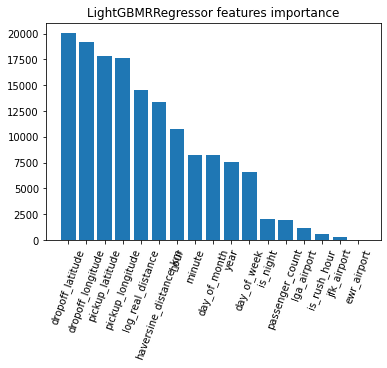

In [ ]:
plt.title("LightGBMRRegressor features importance")
plt.bar(range(len(result)), [val[1] for val in result], align='center')
plt.xticks(range(len(result)), [val[0] for val in result])
plt.xticks(rotation=70)
plt.show()

## **2.3. Random Forest Regressor**

In [ ]:
def cv_random_forest(train,
                          numerical_features, 
                          categorical_features, 
                          target_variable,
                          k_fold=5):
    
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml import Pipeline   
    # 1. Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=numerical_features + categorical_features, outputCol="features")


    if TARGET_VARIABLE != "label":
        train = train.withColumnRenamed(TARGET_VARIABLE, "label")

    rf = RandomForestRegressor(featuresCol="features", labelCol="label")
    
    pipeline = Pipeline(stages=[assembler] +[rf]) # add/remove `[scaler]` to the pipeline if needed

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for lr.regParam ($\lambda$) and 3 values for lr.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 7, 10])\
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                              estimatorParamMaps=param_grid,
                              evaluator=RegressionEvaluator(metricName="rmse"),
                              numFolds=k_fold,
                              collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                              )

    # Run cross-validation, and choose the best set of parameters.

    cv_model = cross_val.fit(train)
    best_pipeline_model = cv_model.bestModel
    # After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset.
    return cv_model, best_pipeline_model
  

In [ ]:
def random_forest_pipeline(train,
                               numerical_features, 
                               categorical_features, 
                               target_variable, 
                               k_fold=5,
                               saved = False):
   if saved :
       from pyspark.ml import PipelineModel
       best_pipeline = PipelineModel.load(PATH_PIPELINE_MODEL_RF)
       return None, best_pipeline
   else:
        cv_model, best_pipeline = cv_random_forest(train,numerical_features, categorical_features, target_variable,k_fold=k_fold) 
        best_pipeline.save(PATH_PIPELINE_MODEL_RF)   
        return cv_model, best_pipeline

In [ ]:
cv_model, best_pipeline_model_rf = random_forest_pipeline(taxi_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE, saved = USE_PICKLE)

### **2.3.1. Train dataset score**




In [ ]:
predictions_train = best_pipeline_model_rf.transform(taxi_df)

In [ ]:
def evaluate_model(predictions, metric:str="rmse"):
    
    from pyspark.ml.evaluation import RegressionEvaluator

    evaluator = RegressionEvaluator(labelCol="fare_amount",
                                    predictionCol="prediction",
                                    metricName=metric)

    return evaluator.evaluate(predictions)

In [ ]:
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_train)))
print("R2: {:.3f}".format(evaluate_model(predictions_train, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_train)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 2.704
R2: 0.834
Adjusted R2: 0.834
***** Training Set *****


### **2.3.2. Validation dataset score**


In [ ]:
predictions_val = best_pipeline_model_rf.transform(taxi_df_val)

In [ ]:
print("***** Validation Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions_val)))
print("R2: {:.3f}".format(evaluate_model(predictions_val, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions_val)))
print("***** Validation Set *****")

***** Validation Set *****
RMSE: 3.270
R2: 0.782
Adjusted R2: 0.782
***** Validation Set *****


### **2.3.3. Feature importance**


In [ ]:
rf_model = best_pipeline_model_rf.stages[-1]
rf_importance_features = rf_model.featureImportances
result = list(zip(NUMERICAL_FEATURES+CATEGORICAL_FEATURES,rf_importance_features))
result.sort(key=lambda x: x[1], reverse=True)          

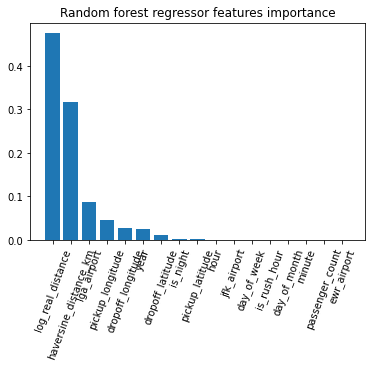

In [ ]:
plt.title("Random forest regressor features importance")
plt.bar(range(len(result)), [val[1] for val in result], align='center')
plt.xticks(range(len(result)), [val[0] for val in result])
plt.xticks(rotation=70)
plt.show()

### **2.3.4. Best parameters**


In [ ]:
get_best_params(best_pipeline_model_rf)

{Param(parent='RandomForestRegressor_22faebf44100', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestRegressor_22faebf44100', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestRegressor_22faebf44100', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(parent='RandomForestRegressor_22faebf44100', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featureSubsetStrategy': 'auto',
 'featuresCol': 'features',
 'impurity': 'variance',
 'labelCol': 'fare_amount',
 'maxBins': 32,
 'maxDepth': 7,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'numTrees': 100,
 'predictionCol': 'prediction',
 'seed': 3959540927479918080,
 'subsamplingRate': 1.0}

# **3. Conclusion**

In [ ]:
SPEED = True
PATH_FINAL_MODEL_LGBM = PATH_FINAL_MODEL+ "/lgbm_final_model"

## **3.1. Load Dataset - Merge Train+Val**

In [ ]:
taxi_df = spark.read.load(PATH_PREPROCESSED+"/train/transformed_dataset_train.csv", 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

In [ ]:
taxi_df = taxi_df.drop("log_fare_amount")

In [ ]:
taxi_df_val = spark.read.load(PATH_PREPROCESSED+"/val/transformed_dataset_val.csv", 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

In [ ]:
taxi_df_test = spark.read.load(PATH_PREPROCESSED+"/test/tmp_dataset_test.csv", 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

In order to use all dataset, we join the train and the validation, and we re-perform the fit of our best model

In [ ]:
taxi_df_merged = taxi_df.union(taxi_df_val)

NameError: ignored

In [ ]:
print("The shape of the MERGED dataset is {:d} rows by {:d} columns".format(taxi_df_merged.count(), len(taxi_df_merged.columns)))

The shape of the MERGED dataset before  is 3300930 rows by 21 columns


## **3.2. Train LGBM Trough The Merged Dataset**

In [ ]:
from mmlspark.lightgbm import LightGBMRegressor    
best_pipeline_model_lgbm = None
if not SPEED:
  from pyspark.ml import Pipeline
  best_pipeline_lgbm = Pipeline.load(PATH_PIPELINE_LGBM)
  best_pipeline_model_lgbm = best_pipeline_lgbm.fit(taxi_df_merged)
  best_pipeline_model_lgbm.save(PATH_FINAL_MODEL_LGBM)
else:
  from pyspark.ml import PipelineModel
  import mmlspark.train
  best_pipeline_model_lgbm = PipelineModel.load(PATH_FINAL_MODEL_LGBM)

## 3.3. Final Evaluation

In [ ]:
final_score = best_pipeline_model_lgbm.transform(taxi_df_test)

In [ ]:
final_score.show()

+-------------------+-----------+------------------+------------------+------------------+------------------+---------------+-------------+---------------+------+----+-----------+------------+----+------------+--------+-----------+-----------+-----------+---------------------+--------------------+--------------------+--------------------+------------------+
|                key|fare_amount|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|real_distance|pickup_datetime|minute|hour|day_of_week|day_of_month|year|is_rush_hour|is_night|jfk_airport|ewr_airport|lga_airport|haversine_distance_km|   log_real_distance|            features|        std_features|        prediction|
+-------------------+-----------+------------------+------------------+------------------+------------------+---------------+-------------+---------------+------+----+-----------+------------+----+------------+--------+-----------+-----------+-----------+---------------------+---

In [ ]:
from mmlspark.train import ComputeModelStatistics
print("***** FINAL Test Set *****")
metrics = ComputeModelStatistics(evaluationMetric='rmse',
                                 labelCol='fare_amount',
                                 scoresCol='prediction') \
            .transform(final_score)
metrics.toPandas() 

***** FINAL Test Set *****


Py4JJavaError: ignored

In [ ]:
def evaluate_model(predictions, metric="rmse"):
    
    from pyspark.ml.evaluation import RegressionEvaluator

    evaluator = RegressionEvaluator(labelCol="fare_amount",
                                    predictionCol="prediction",
                                    metricName=metric)

    return evaluator.evaluate(predictions)

In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(final_score)))

***** Training Set *****
RMSE: 5.119
